# Comparative study of YOLO vs MediaPipe vs MoveNet vs OpenPose vs HRNet


Importing Dataset

In [1]:
!git clone https://github.com/Vishveshwara/Comparison-of-HPE-Models.git

Cloning into 'Comparison-of-HPE-Models'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 41 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 643.32 KiB | 1.38 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
!pip install ultralytics
!pip install mediapipe
!pip install tensorflow_docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.1/877.1 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 4.2 MB/s eta 0:00:00


In [30]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

import mediapipe as mp

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed


import numpy as np

# Assume KEYPOINT_DICT is a dictionary that maps YOLO keypoints to Mediapipe keypoints
KEYPOINT_DICT = {
    0: "nose",
    5: "left_shoulder",
    6: "right_shoulder",
    7: "left_elbow",
    8: "right_elbow",
    9: "left_wrist",
    10: "right_wrist",
    11: "left_hip",
    12: "right_hip",
    13: "left_knee",
    14: "right_knee",
    15: "left_ankle",
    16: "right_ankle"
}

# Load the input image.
image_path = '/content/Comparison-of-HPE-Models/Yoga poses.v5i.yolov8/test/images/00000178_JPG_jpg.rf.0a19581547f49840903f4a31f90ad61e.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display with matplotlib

# File path to your YOLO txt file
file_path = '/content/Comparison-of-HPE-Models/Yoga poses.v5i.yolov8/test/labels/00000178_JPG_jpg.rf.0a19581547f49840903f4a31f90ad61e.txt'

try:
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.read()
except UnicodeDecodeError:
    print("UTF-8 decoding failed, trying ISO-8859-1 encoding...")
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        data = file.read()

## Define Metrics

In [17]:
def calculate_oks(gt_keypoints, pred_keypoints, bbox_area, indices):
    # Object Keypoint Similarity (OKS) is a metric used to evaluate the accuracy of keypoint predictions

    sigmas = np.array([0.1]*17)

    #Filter keypoints
    selected_sigmas = []

    for j in indices:
        selected_sigmas.append(sigmas[j])

    #print("gt_kpts: ", gt_keypoints)

    # Ensure both keypoints lists have exactly 13 keypoints
    gt_keypoints = gt_keypoints[:13]
    pred_keypoints = pred_keypoints[:13]


    y_true = np.array(gt_keypoints).reshape(-1, 2)
    y_pred = np.array(pred_keypoints).reshape(-1, 2)

    #print("ytrue: ", y_true)
    #print("ypred: ", y_pred)

    # Handle cases where there might be fewer keypoints
    if y_true.shape[0] != y_pred.shape[0]:
        raise ValueError(f"Shape mismatch between ground truth and predicted keypoints: {y_true.shape} vs {y_pred.shape}")


    # Calculate Euclidean distance between keypoints
    d2 = (y_true - y_pred)**2
    # d^2 = (x1 - x2)^2 + (y1 - y2)^2
    d2_sum = d2.sum(axis=1)

    #print(d2_sum)


    # Adjust sigmas shape if necessary
    if sigmas.shape[0] != d2.shape[1]:
        sigmas = sigmas[:d2.shape[1]]

    # COCO assigns k = 2σ.
    for i in range(len(selected_sigmas)):
        selected_sigmas[i] = 2 * selected_sigmas[i]

    #print(selected_sigmas)

    denom=[]
    # Denominator in the exponent term. Shape: [M, 1, #kpts]
    for k in range(len(selected_sigmas)):
        denom.append( 2 * (selected_sigmas[k]**2) * bbox_area )

    #print( -d2_sum/denom )

    # Calculate OKS
    oks = np.exp(-d2_sum / denom )

    print(oks)

    return oks.mean()


def calculate_mppe(gt_keypoints, pred_keypoints):
    # Mean Per Part Error (MPPE) is the average error between predicted and ground truth parts detected (pairs of keypoints)

    # Ensure both keypoints lists have exactly 13 keypoints by truncating or padding
    def adjust_keypoints(keypoints, target_len=13):
        # If there are more than 13 keypoints, truncate the list
        if len(keypoints) > target_len:
            keypoints = keypoints[:target_len]
        # If there are fewer than 13, pad with (0,0) to make up the difference
        else:
            while len(keypoints) < target_len:
                keypoints.append([0, 0])  # Padding with [0, 0] for missing keypoints
        return keypoints

    # Adjust the shape of both ground truth and predicted keypoints
    gt_keypoints = adjust_keypoints(gt_keypoints)
    pred_keypoints = adjust_keypoints(pred_keypoints)

    # Handle missing keypoints by replacing them with a placeholder
    def handle_missing_keypoints(keypoints):
        # Use np.array_equal to compare arrays
        return [[0, 0] if np.array_equal(k, [0, 0]) else k for k in keypoints]

    gt_keypoints = handle_missing_keypoints(gt_keypoints)
    pred_keypoints = handle_missing_keypoints(pred_keypoints)

    error_array = []

    # Converted limb pairs based on keypoints array
    limb_pairs = [(1, 9), (9, 11), (2, 10), (10, 12), (3, 5), (5, 7), (4, 6), (6, 8)]

    for (i, j) in limb_pairs:
        # Skip the part if either keypoint in the pair is missing
        if np.array_equal(gt_keypoints[i], [0, 0]) or np.array_equal(gt_keypoints[j], [0, 0]):
            continue

        gt_dist = np.linalg.norm(np.array(gt_keypoints[i]) - np.array(gt_keypoints[j]))
        pred_dist = np.linalg.norm(np.array(pred_keypoints[i]) - np.array(pred_keypoints[j]))

        # Check if the predicted distance is within a threshold
        error_array.append(abs(gt_dist - pred_dist) / gt_dist)

    # If no valid error was calculated (empty error array), return a fallback value (like 0)
    if len(error_array) == 0:
        return 0

    return np.mean(error_array)

## Deploying models and extracting predicted keypoints

### MoveNet

In [37]:
module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
input_size = 192

def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores


import time
start_time = time.time()

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Elapsed time: {elapsed_time_ms:.2f} ms")
fps_movenet = 1000 / elapsed_time_ms

#print("Keypoints with scores: ", keypoints_with_scores)


#---------------------------------Predicted Keypoints---------------------------------

predicted_kpts = []   #normalized

coco_indices = [0, 6, 5, 11, 12, 14, 13, 16, 15, 7, 9, 8, 10]   #order of keypoints presented in the dataset, check keypoint dictionary to verify which joint is which

#Filter the keypoints to only include the ones we want
for i in coco_indices:
    predicted_kpts.append(keypoints_with_scores[0][0][i])

print("Predicted keypoints: ", predicted_kpts)

# Convert normalized coordinates to image pixel coordinates
pred_kpts = []
for kp in predicted_kpts:
    x = kp[0] * 640
    y = kp[1] * 640
    pred_kpts.append([y, x])

print("Predicted keypoints: ", pred_kpts)

pred_movenet = pred_kpts

Elapsed time: 632.01 ms
Predicted keypoints:  [array([    0.19091,     0.48137,     0.57605], dtype=float32), array([    0.26921,     0.37006,     0.78781], dtype=float32), array([    0.26697,     0.60815,     0.83746], dtype=float32), array([    0.51349,     0.57722,     0.73381], dtype=float32), array([    0.54142,     0.44666,     0.86984], dtype=float32), array([    0.71631,     0.46142,     0.58697], dtype=float32), array([    0.57079,     0.84403,     0.84527], dtype=float32), array([    0.72893,     0.48881,     0.14062], dtype=float32), array([    0.60001,     0.55406,      0.4254], dtype=float32), array([    0.39302,     0.65385,     0.79587], dtype=float32), array([    0.30593,     0.51112,     0.54224], dtype=float32), array([    0.38676,      0.3001,     0.73496], dtype=float32), array([    0.30372,     0.44902,     0.53106], dtype=float32)]
Predicted keypoints:  [[308.0790328979492, 122.18191146850586], [236.83795928955078, 172.2919464111328], [389.2163848876953, 170.85954

### Mediapipe

In [38]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

def process_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    return results, image_rgb

start_time = time.time()
results, image_rgb = process_image(image_path)

end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Elapsed time: {elapsed_time_ms:.2f} ms")
fps_mediapipe = 1000 / elapsed_time_ms


# Get image dimensions
image_height, image_width, _ = image.shape


mediapipe_indices = [0, 12, 11, 23, 24, 26, 25, 28, 27, 13, 15, 14, 16]     #order of keypoints presented in the dataset


# ----------------------------------Predicted keypoints----------------------------------------------

# Extract the 13 keypoints from MediaPipe according to KEYPOINT_DICT
if results.pose_landmarks:
    keypoints = results.pose_landmarks.landmark
    pred_kpts = []

    # Loop over selected keypoints in KEYPOINT_DICT
    for i in mediapipe_indices:
        kp = keypoints[i]
        # Normalize keypoints to YOLO format (x and y between 0 and 1)
        x = kp.x * image_width
        y = kp.y * image_height
        pred_kpts.append((x, y))

    # Convert keypoints to numpy array for easier manipulation
    pred_kpts = np.array(pred_kpts)
    print(pred_kpts)

    pred_mp = pred_kpts

Elapsed time: 247.24 ms
[[     314.32      124.12]
 [     243.23      178.44]
 [     385.25      178.79]
 [     373.54      342.48]
 [     286.67      360.63]
 [     289.34      440.13]
 [     525.79      370.84]
 [     334.67      584.89]
 [     345.71       393.9]
 [     418.48      255.84]
 [     323.36      199.08]
 [     189.73      248.43]
 [     292.45      198.99]]


### YOLOv8

In [40]:
# Load a pretrained YOLO model (recommended for training)
model = YOLO('yolov8m-pose.pt')

# Perform object detection on an image using the model
start_time = time.time()

results = model(image_path)

end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Elapsed time: {elapsed_time_ms:.2f} ms")
fps_yolo = 1000 / elapsed_time_ms


# Define the indices for the 13 keypoints we need
# Using MediaPipe indices:
# 0: Nose, 5: Left Shoulder, 6: Right Shoulder, 11: Left Hip, 12: Right Hip,
# 13: Left Knee, 14: Right Knee, 15: Left Ankle, 16: Right Ankle, 7: Left Elbow, 8: Right Elbow,
# 9: Left Wrist, 10: Right Wrist
selected_indices = [0, 6, 5, 11, 12, 14, 13, 16, 15, 7, 9, 8, 10]       #order of keypoints presented in the dataset


# ----------------------------------Predicted keypoints----------------------------------------------
denormalized_kps = []

# Process results
for r in results:
    keypoints = r.keypoints.xyn.cpu().numpy()  # Normalized keypoints (x, y, conf)

    for kp in keypoints[0]:
            x, y = int(kp[0] * 640), int(kp[1] * 640) # denormalize , if needed
            denormalized_kps.append((x,y))

pred_kpts = []

# Filter for the 13 specific keypoints
for i in selected_indices:
    pred_kpts.append(denormalized_kps[i])

print("Predicted keypoints: ", pred_kpts)

pred_yolo = pred_kpts


image 1/1 /content/Comparison-of-HPE-Models/Yoga poses.v5i.yolov8/test/images/00000178_JPG_jpg.rf.0a19581547f49840903f4a31f90ad61e.jpg: 640x640 1 person, 1627.9ms
Speed: 2.6ms preprocess, 1627.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Elapsed time: 2222.35 ms
Predicted keypoints:  [(310, 119), (220, 189), (391, 169), (400, 334), (290, 364), (311, 451), (463, 326), (332, 593), (350, 413), (406, 243), (336, 204), (199, 244), (274, 210)]


## Extracting ground truth keypoints from dataset

In [41]:
#++++++++++++++++++++++++++++++++++++++Ground Truth Keypoints++++++++++++++++++++++++++++++++++++++

normal_gt_kpts = [float(value) for i, value in enumerate(data.split()) if 0 < float(value) <= 1 ]


# Reshape keypoints into pairs of (x, y)
normal_gt_kpts = np.array(normal_gt_kpts).reshape(-1, 2)

# Denormalize keypoints
gt_kpts = np.zeros_like(normal_gt_kpts)
gt_kpts[:, 0] = normal_gt_kpts[:, 0] * 640   # Denormalize x by image width
gt_kpts[:, 1] = normal_gt_kpts[:, 1] * 640  # Denormalize y by image height


#print(gt_kpts[2:])
# print(selected_keypoints) visualization and debugging

gt_kpts = gt_kpts[2:]   # remove the first two keypoints as they are part of bbox *VERY IMPORTANT*

#print("Ground truth keypoints: ", gt_kpts)

In [42]:
gt_kpts

array([[     312.73,      118.18],
       [     223.64,      178.18],
       [     395.45,      176.36],
       [     396.36,      323.64],
       [     252.73,      352.73],
       [     301.82,      460.91],
       [        540,      371.82],
       [     341.82,      594.55],
       [     363.64,      390.91],
       [     419.09,      258.18],
       [     331.82,      205.45],
       [     186.36,      256.36],
       [     287.27,      202.73]])

## Inference and metrics evaluation for each neural network

### MoveNet

[    0.99784     0.98804     0.99602     0.95768     0.93665     0.99721     0.99756     0.37075     0.99258     0.99744     0.99338     0.99365       0.996]
OKS MoveNet:  0.9395996464947987
MPPE MoveNet:  0.1714874787467772
FPS MoveNet 1.5822588597621956


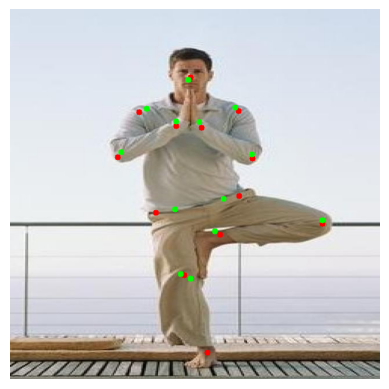

In [43]:
print("OKS MoveNet: ", calculate_oks(gt_kpts, pred_movenet, 640*640*0.53, coco_indices))
print("MPPE MoveNet: ", calculate_mppe(gt_kpts, pred_movenet))
print("FPS MoveNet",fps_movenet)

image_mp = image_rgb.copy()
image_yolo = image_rgb.copy()

# Draw ground truth keypoints on the image
for x, y in gt_kpts:
    cv2.circle(image, (int(x), int(y)), 5, (255, 0, 0), -1)  # Red circles for ground truth keypoints

for x,y in pred_movenet:
    cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)  # Green circles for predicted keypoints

# Display the image with keypoints
plt.imshow(image)
plt.axis('off')
plt.show()

### Mediapipe

[    0.99783     0.97813     0.99368     0.95081     0.93245     0.96672     0.98838     0.99173     0.98117     0.99966     0.99356     0.99573     0.99766]
OKS Mediapipe:  0.9821155752858517
MPPE Mediapipe:  0.12402084693643761
FPS Mediapipe 4.044675282595656


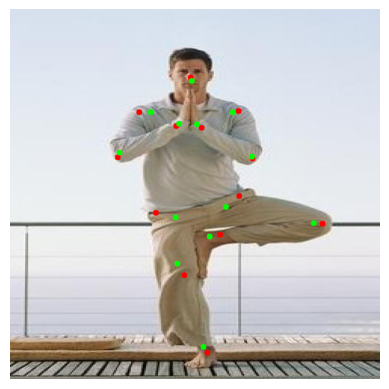

In [44]:
print("OKS Mediapipe: ", calculate_oks(gt_kpts, pred_mp, 640*640*0.53, coco_indices))
print("MPPE Mediapipe: ", calculate_mppe(gt_kpts, pred_mp))
print("FPS Mediapipe",fps_mediapipe)

image_mp = image_rgb.copy()


# Draw ground truth keypoints on the image
for x, y in gt_kpts:
    cv2.circle(image_mp, (int(x), int(y)), 5, (255, 0, 0), -1)  # Red circles for ground truth keypoints

for x,y in pred_mp:
    cv2.circle(image_mp, (int(x), int(y)), 5, (0, 255, 0), -1)  # Green circles for predicted keypoints

# Display the image with keypoints
plt.imshow(image_mp)
plt.axis('off')
plt.show()

### YOLOv8

[    0.99953     0.99253     0.99574     0.99308     0.91639     0.98955     0.62985     0.99433     0.96194     0.97713     0.99887     0.98216      0.9869]
OKS YOLO:  0.955230686123923
MPPE YOLO:  0.17318164422338678
FPS YOLO 0.4499748261945327


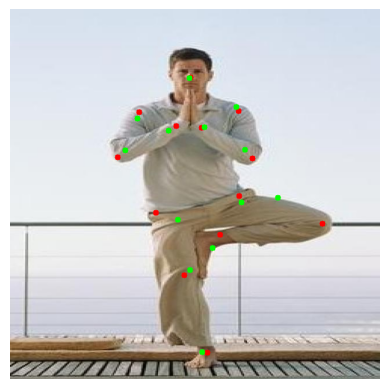

In [45]:
print("OKS YOLO: ", calculate_oks(gt_kpts, pred_yolo, 640*640*0.53, coco_indices))
print("MPPE YOLO: ", calculate_mppe(gt_kpts, pred_yolo))
print("FPS YOLO",fps_yolo)
image_yolo = image_rgb.copy()

# Draw ground truth keypoints on the image
for x, y in gt_kpts:
    cv2.circle(image_yolo, (int(x), int(y)), 5, (255, 0, 0), -1)  # Red circles for ground truth keypoints

for x,y in pred_yolo:
    cv2.circle(image_yolo, (int(x), int(y)), 5, (0, 255, 0), -1)  # Green circles for predicted keypoints

# Display the image with keypoints
plt.imshow(image_yolo)
plt.axis('off')
plt.show()

OpenPose Model

In [46]:
import cv2 as cv

In [49]:
frame = cv.imread(image_path)

# Load OpenPose model
model_path = "/content/Comparison-of-HPE-Models/graph_opt.pb"
net = cv.dnn.readNetFromTensorflow(model_path)

# Define BODY_PARTS and POSE_PAIRS (same as original)
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

# Set dimensions for input image
inWidth = 368
inHeight = 368
threshold = 0.2

# Prepare input for OpenPose
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]

start = time.time()
net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
out = net.forward()
out = out[:, :19, :, :]  # Extract the first 19 body parts
end = time.time()
elapsed_time_ms = (end - start) * 1000
print(f"Elapsed time: {elapsed_time_ms:.2f} ms")
fps_openpose = 1000 / elapsed_time_ms

# Extract keypoints
points = []
for i in range(len(BODY_PARTS)):
    heatMap = out[0, i, :, :]
    _, conf, _, point = cv.minMaxLoc(heatMap)
    x = (frameWidth * point[0]) / out.shape[3]
    y = (frameHeight * point[1]) / out.shape[2]
    points.append((int(x), int(y)) if conf > threshold else None)

Elapsed time: 351.31 ms


In [50]:
media_to_openpose_indices = {
    0: 0,   # Nose
    12: 2,  # Right Shoulder
    11: 5,  # Left Shoulder
    23: 11, # Left Hip
    24: 8,  # Right Hip
    26: 9,  # Right Knee
    25: 12, # Left Knee
    28: 10, # Right Ankle
    27: 13, # Left Ankle
    13: 6,  # Left Elbow
    15: 7,  # Left Wrist
    14: 3,  # Right Elbow
    16: 4   # Right Wrist
}

In [51]:
mediapipe_indices = [0, 12, 11, 23, 24, 26, 25, 28, 27, 13, 15, 14, 16]

In [52]:
kp = []
for i in mediapipe_indices:
    # Get the corresponding OpenPose index
    openpose_idx = media_to_openpose_indices.get(i)

    # Fetch the OpenPose keypoint
    x = points[openpose_idx] if openpose_idx is not None else (0, 0)

    kp.append(x)

# kp now contains the converted keypoints
kp

[(306, 111),
 (236, 180),
 (375, 166),
 (375, 333),
 (278, 361),
 (292, 445),
 None,
 (306, 570),
 None,
 (403, 250),
 (333, 208),
 (194, 236),
 (278, 194)]

In [55]:
for i,a in enumerate(kp):
  #print(a)
  if a is None:
    kp[i] = (0,0)
kp

[(306, 111),
 (236, 180),
 (375, 166),
 (375, 333),
 (278, 361),
 (292, 445),
 (0, 0),
 (306, 570),
 (0, 0),
 (403, 250),
 (333, 208),
 (194, 236),
 (278, 194)]

In [56]:
pred_kpts_openpose = np.array(kp)
print(pred_kpts_openpose)

[[306 111]
 [236 180]
 [375 166]
 [375 333]
 [278 361]
 [292 445]
 [  0   0]
 [306 570]
 [  0   0]
 [403 250]
 [333 208]
 [194 236]
 [278 194]]


[    0.99444     0.99105     0.97018     0.96916      0.9601     0.98008  1.7818e-11     0.89712  7.4477e-08     0.98141     0.99955     0.97313     0.99071]
OKS OpenPose:  0.8236092999642884
MPPE OpenPose:  0.3137391275287005
FPS Openpose 2.8464790777913356


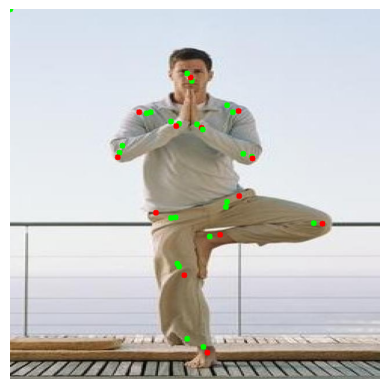

In [57]:
print("OKS OpenPose: ", calculate_oks(gt_kpts, pred_kpts_openpose, 640*640*0.53, coco_indices))
print("MPPE OpenPose: ", calculate_mppe(gt_kpts, pred_kpts_openpose))
print("FPS Openpose",fps_openpose)

# Draw ground truth keypoints on the image
for x, y in gt_kpts:
    cv2.circle(image_mp, (int(x), int(y)), 5, (255, 0, 0), -1)  # Red circles for ground truth keypoints

for x,y in pred_kpts_openpose:
    cv2.circle(image_mp, (int(x), int(y)), 5, (0, 255, 0), -1)  # Green circles for predicted keypoints

# Display the image with keypoints
plt.imshow(image_mp)
plt.axis('off')
plt.show()

HRNET Model

In [58]:
!git clone https://github.com/stefanopini/simple-HRNet.git

Cloning into 'simple-HRNet'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 420 (delta 85), reused 73 (delta 73), pack-reused 319 (from 1)
Receiving objects: 100% (420/420), 78.05 MiB | 27.30 MiB/s, done.
Resolving deltas: 100% (217/217), done.


In [59]:
%cd simple-HRNet
!pwd

/content/simple-HRNet
/content/simple-HRNet


In [60]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.0 MB/s eta 0:00:00


In [61]:
# download git submodules
!git submodule update --init --recursive

Submodule 'models/detectors/yolo' (https://github.com/eriklindernoren/PyTorch-YOLOv3) registered for path 'models_/detectors/yolo'
Cloning into '/content/simple-HRNet/models_/detectors/yolo'...
Submodule path 'models_/detectors/yolo': checked out '47b7c912877ca69db35b8af3a38d6522681b3bb3'


In [62]:
%cd /content/simple-HRNet/models_/detectors/yolo
!pip install -q -r requirements.txt

%cd /content/simple-HRNet


/content/simple-HRNet/models_/detectors/yolo
/content/simple-HRNet


In [63]:
%cd /content/simple-HRNet/models_/detectors/yolo/weights
!sh download_weights.sh

%cd /content/simple-HRNet

/content/simple-HRNet/models_/detectors/yolo/weights
--2024-10-24 15:02:24--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  32.1MB/s    in 7.0s    

2024-10-24 15:02:31 (33.7 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-10-24 15:02:31--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  29.2MB/s    in 1.2s    

2024-10-24 15:02:33 (29.2 MB/s) - ‘yolo

In [64]:
!pip install --upgrade --no-cache-dir gdown

In [65]:
# download weights

# create weights folder
%cd /content/simple-HRNet
!mkdir weights
%cd /content/simple-HRNet/weights

# download weights pose_hrnet_w48_384x288.pth
!gdown 1UoJhTtjHNByZSm96W3yFTfU5upJnsKiS

# download weights pose_hrnet_w32_256x192.pth
!gdown 1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38

# download weights pose_hrnet_w32_256x256.pth
!gdown 1_wn2ifmoQprBrFvUCDedjPON4Y6jsN-v

# # download weights from your own Google Drive
# from glob import glob
# from google.colab import drive
# drive.mount('/content/drive')
# w_list = glob("/content/drive//*.pth")
# if not w_list:
#   raise FileNotFoundError("You haven't downloaded any pre-trained weights!")

%cd /content/simple-HRNet

/content/simple-HRNet
/content/simple-HRNet/weights
Downloading...
From (original): https://drive.google.com/uc?id=1UoJhTtjHNByZSm96W3yFTfU5upJnsKiS
From (redirected): https://drive.google.com/uc?id=1UoJhTtjHNByZSm96W3yFTfU5upJnsKiS&confirm=t&uuid=06edce59-8330-43c1-932a-7c09b8ebac67
To: /content/simple-HRNet/weights/pose_hrnet_w48_384x288.pth
100% 255M/255M [00:05<00:00, 46.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38
From (redirected): https://drive.google.com/uc?id=1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38&confirm=t&uuid=a527efc0-f800-4f1e-8c03-1952e8976c7b
To: /content/simple-HRNet/weights/pose_hrnet_w32_256x192.pth
100% 115M/115M [00:02<00:00, 52.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1_wn2ifmoQprBrFvUCDedjPON4Y6jsN-v
From (redirected): https://drive.google.com/uc?id=1_wn2ifmoQprBrFvUCDedjPON4Y6jsN-v&confirm=t&uuid=f1abdd5a-13d4-4c42-9105-e4de142a30d0
To: /content/simple-HRNet/weights/pose_hrnet_w32_

In [66]:
import cv2
import requests
import matplotlib.pyplot as plt
import torch
from skimage import io
from PIL import Image
from SimpleHRNet import SimpleHRNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # singleperson, COCO weights
model = SimpleHRNet(48, 17, "./weights/pose_hrnet_w48_384x288.pth", multiperson=False, device=device)

device: 'cpu'


In [67]:
# # multiperson w/ YOLOv3, COCO weights
# model = SimpleHRNet(48, 17, "./weights/pose_hrnet_w48_384x288.pth", device=device)

# # multiperson w/ YOLOv3, COCO weights, small model
# model = SimpleHRNet(32, 17, "./weights/pose_hrnet_w32_256x192.pth", device=device)

# # multiperson w/ YOLOv3, MPII weights
# model = SimpleHRNet(32, 16, "./weights/pose_hrnet_w32_256x256.pth", device=device)

# # multiperson w/ YOLOv5 (medium), COCO weights
# model = SimpleHRNet(48, 17, "./weights/pose_hrnet_w48_384x288.pth", yolo_version='v5', yolo_model_def='yolov5m', device=device)

# multiperson w/ YOLOv5 nano, COCO weights, small model
#model = SimpleHRNet(32, 17, "./weights/pose_hrnet_w32_256x192.pth", yolo_version='v5', yolo_model_def='yolov5n', device=device)


In [68]:
image_path = '/content/Comparison-of-HPE-Models/Yoga poses.v5i.yolov8/test/images/00000027_jpg.rf.19bf51a58119edcb6965d75f38d00ff7.jpg'
Image = cv2.imread(image_path)
Image = cv2.cvtColor(Image, cv2.COLOR_BGR2RGB)

array([[[214, 180, 132],
        [214, 180, 132],
        [214, 180, 132],
        ...,
        [214, 189, 159],
        [214, 189, 159],
        [214, 189, 159]],

       [[214, 180, 132],
        [214, 180, 132],
        [214, 180, 132],
        ...,
        [215, 190, 160],
        [215, 190, 160],
        [214, 189, 159]],

       [[214, 180, 132],
        [214, 180, 132],
        [214, 180, 132],
        ...,
        [216, 191, 161],
        [216, 191, 161],
        [215, 190, 160]],

       ...,

       [[166,  98,  37],
        [166,  98,  37],
        [167,  99,  36],
        ...,
        [203, 127,  52],
        [203, 127,  52],
        [203, 127,  52]],

       [[167,  99,  38],
        [168, 100,  39],
        [168, 100,  37],
        ...,
        [205, 129,  54],
        [205, 129,  54],
        [205, 129,  54]],

       [[171, 103,  42],
        [171, 103,  42],
        [172, 104,  41],
        ...,
        [204, 128,  53],
        [204, 128,  53],
        [204, 128,  53]]], dtype=uint8)
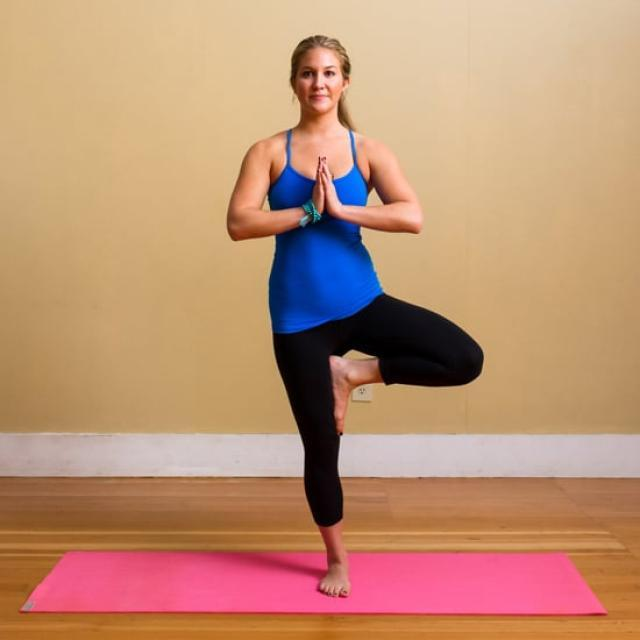

In [69]:
Image

In [73]:
import time
start_time = time.time()
joints = model.predict(Image)
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Elapsed time: {elapsed_time_ms:.2f} ms")
fps = 1000 / elapsed_time_ms
print(f"FPS: {fps:.2f} fps")

Elapsed time: 1553.08 ms
FPS: 0.64 fps


In [74]:
joints

array([[[         80,         320,     0.98076],
        [     73.333,      328.89,     0.99623],
        [     73.333,      302.22,     0.96728],
        [         80,      346.67,      0.9817],
        [         80,      293.33,     0.96873],
        [     153.33,      364.44,     0.96314],
        [     153.33,      266.67,     0.95944],
        [        220,      408.89,     0.98248],
        [        220,         240,     0.97308],
        [     213.33,      337.78,     0.80948],
        [     206.67,      311.11,     0.94194],
        [     306.67,      364.44,     0.88383],
        [        320,      302.22,     0.90766],
        [        360,      462.22,     0.92246],
        [     433.33,         320,     0.92654],
        [     373.33,      346.67,     0.92319],
        [        560,      337.78,     0.94812]]], dtype=float32)

[[15, 13], [13, 11], [16, 14], [14, 12], [11, 12], [5, 11], [6, 12], [5, 6], [5, 7], [6, 8], [7, 9], [8, 10], [1, 2], [0, 1], [0, 2], [1, 3], [2, 4], [0, 5], [0, 6]]


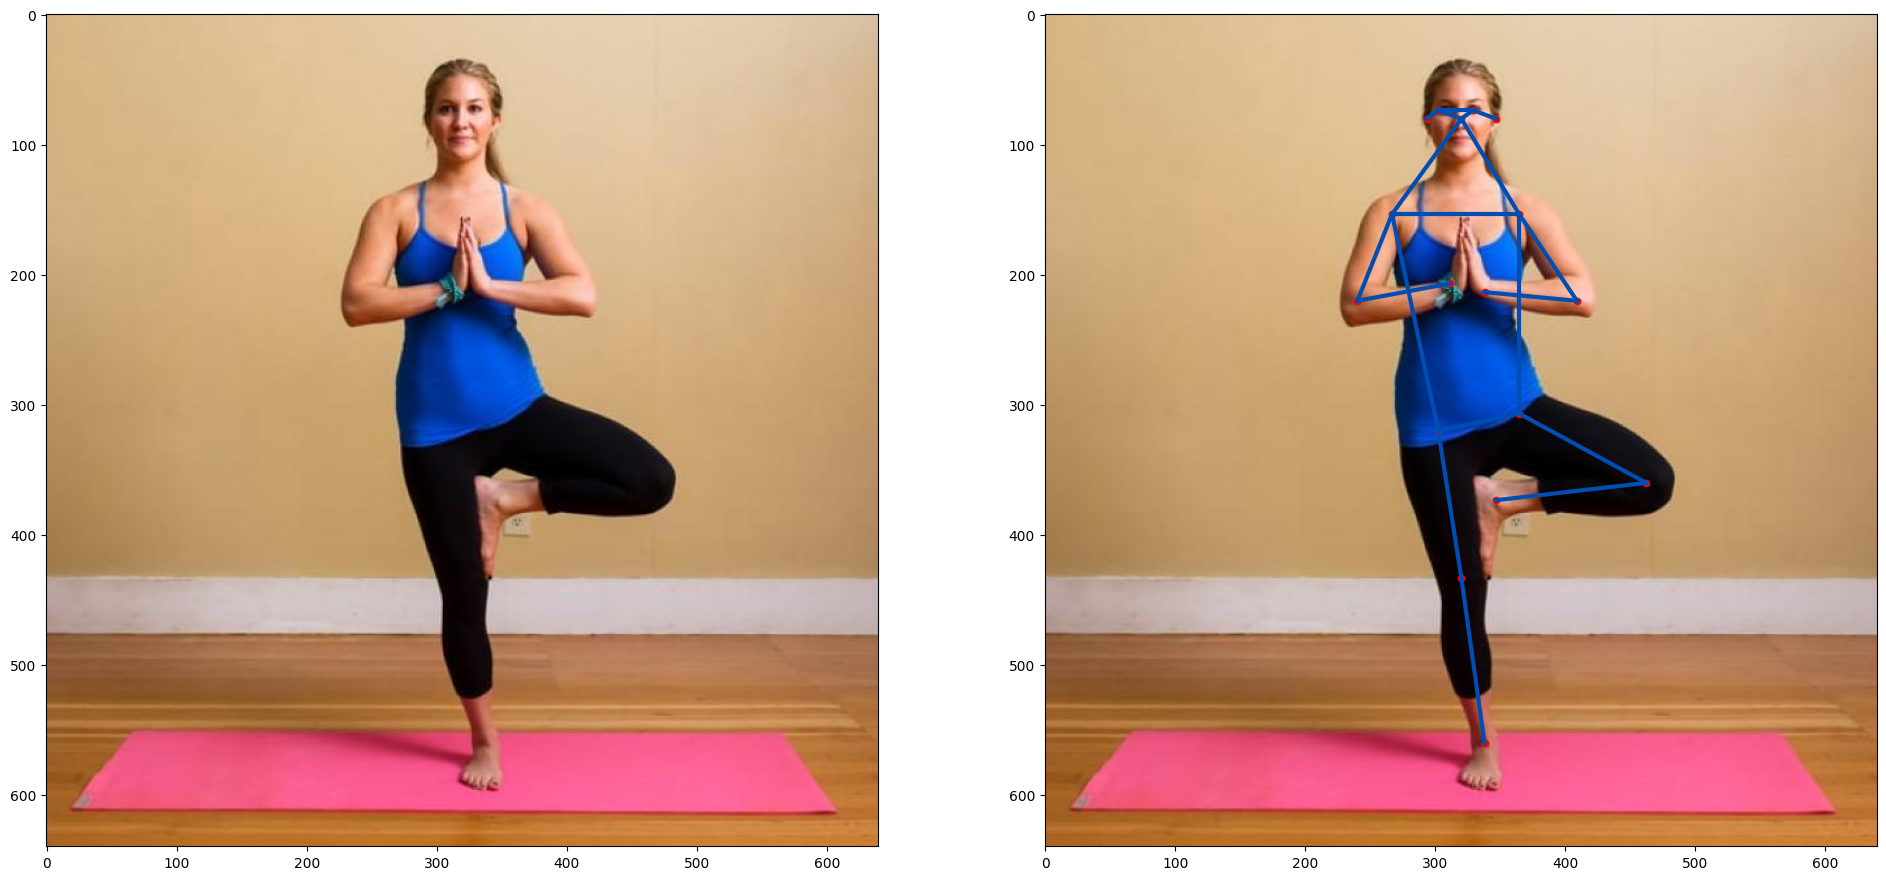

In [75]:
%matplotlib inline
from misc.visualization import joints_dict

def plot_joints(ax, output):
    # Check if output is empty
    if output.size == 0:
        print("Warning: No joints detected in the image.")
        return  # Exit the function if no joints are found

    bones = joints_dict()["coco"]["skeleton"]
    print(bones)
    # bones = joints_dict()["mpii"]["skeleton"]

    for bone in bones:
        xS = [output[:,bone[0],1], output[:,bone[1],1]]
        yS = [output[:,bone[0],0], output[:,bone[1],0]]
        ax.plot(xS, yS, linewidth=3, c=(0,0.3,0.7))
    ax.scatter(joints[:,:,1],joints[:,:,0], s=20, c='r')

fig = plt.figure(figsize=(60/2.54, 30/2.54))
ax = fig.add_subplot(121)
ax.imshow(Image)
ax = fig.add_subplot(122)
ax.imshow(Image)

# Check if joints is empty before calling plot_joints
if joints.size != 0:
    plot_joints(ax, joints)
else:
    print("Warning: No joints detected in the image.")

plt.show()

In [76]:
# Extract the x and y coordinates
x_coords = joints[:,:,0]  # x-coordinates
y_coords = joints[:,:,1]  # y-coordinates

# Printing x and y coordinates
print("X coordinates of keypoints:", x_coords)
print("Y coordinates of keypoints:", y_coords)

# If you want to access them as pairs (x, y):
keypoints = np.stack((x_coords, y_coords), axis=-1)  # Shape will be (n_points, 2)
print("Keypoint pairs (x, y):", keypoints)

X coordinates of keypoints: [[         80      73.333      73.333          80          80      153.33      153.33         220         220      213.33      206.67      306.67         320         360      433.33      373.33         560]]
Y coordinates of keypoints: [[        320      328.89      302.22      346.67      293.33      364.44      266.67      408.89         240      337.78      311.11      364.44      302.22      462.22         320      346.67      337.78]]
Keypoint pairs (x, y): [[[         80         320]
  [     73.333      328.89]
  [     73.333      302.22]
  [         80      346.67]
  [         80      293.33]
  [     153.33      364.44]
  [     153.33      266.67]
  [        220      408.89]
  [        220         240]
  [     213.33      337.78]
  [     206.67      311.11]
  [     306.67      364.44]
  [        320      302.22]
  [        360      462.22]
  [     433.33         320]
  [     373.33      346.67]
  [        560      337.78]]]


In [77]:
keypoints

array([[[         80,         320],
        [     73.333,      328.89],
        [     73.333,      302.22],
        [         80,      346.67],
        [         80,      293.33],
        [     153.33,      364.44],
        [     153.33,      266.67],
        [        220,      408.89],
        [        220,         240],
        [     213.33,      337.78],
        [     206.67,      311.11],
        [     306.67,      364.44],
        [        320,      302.22],
        [        360,      462.22],
        [     433.33,         320],
        [     373.33,      346.67],
        [        560,      337.78]]], dtype=float32)

In [78]:
mediapipe_to_hrnet_indices = {
    0: 0,   # Nose -> Nose
    12: 6,  # Right Shoulder -> Right Shoulder
    11: 5,  # Left Shoulder -> Left Shoulder
    23: 12, # Left Hip -> Left Hip
    24: 13, # Right Hip -> Right Hip
    26: 14, # Right Knee -> Right Knee
    25: 11, # Left Knee -> Left Knee
    28: 16, # Right Ankle -> Right Ankle
    27: 15, # Left Ankle -> Left Ankle
    13: 7,  # Left Elbow -> Left Elbow
    15: 9,  # Left Wrist -> Left Wrist
    14: 8,  # Right Elbow -> Right Elbow
    16: 10  # Right Wrist -> Right Wrist
}
mediapipe_indices = [0, 12, 11, 23, 24, 26, 25, 28, 27, 13, 15, 14, 16]

# Initialize an empty list to store the HRNet keypoints
hrnet_kp = []

# Iterate through the Mediapipe indices and map them to HRNet keypoints
for i in mediapipe_indices:
    # Get the corresponding HRNet index using the mapping
    hrnet_idx = mediapipe_to_hrnet_indices.get(i)

    # Ensure hrnet_idx is within bounds before accessing the keypoints
    if hrnet_idx is not None and hrnet_idx < keypoints.shape[1]:
        # Fetch the HRNet keypoint
        x = keypoints[0, hrnet_idx, :]  # Assuming single person detection
    else:
        x = (0, 0)

    # Append the HRNet keypoint to the list
    hrnet_kp.append(x)

# hrnet_kp now contains the converted keypoints in HRNet format
hrnet_kp

[array([         80,         320], dtype=float32),
 array([     153.33,      266.67], dtype=float32),
 array([     153.33,      364.44], dtype=float32),
 array([        320,      302.22], dtype=float32),
 array([        360,      462.22], dtype=float32),
 array([     433.33,         320], dtype=float32),
 array([     306.67,      364.44], dtype=float32),
 array([        560,      337.78], dtype=float32),
 array([     373.33,      346.67], dtype=float32),
 array([        220,      408.89], dtype=float32),
 array([     213.33,      337.78], dtype=float32),
 array([        220,         240], dtype=float32),
 array([     206.67,      311.11], dtype=float32)]

In [79]:
file_path = '/content/Comparison-of-HPE-Models/Yoga poses.v5i.yolov8/test/labels/00000027_jpg.rf.19bf51a58119edcb6965d75f38d00ff7.txt'
with open(file_path, 'r', encoding='ISO-8859-1') as file:
        data = file.read()

In [81]:
normal_gt_kpts = [float(value) for i, value in enumerate(data.split()) if 0 < float(value) <= 1]

# Reshape and denormalize ground truth keypoints
normal_gt_kpts = np.array(normal_gt_kpts).reshape(-1, 2)
gt_kpts = np.zeros_like(normal_gt_kpts)
gt_kpts[:, 0] = normal_gt_kpts[:, 0] * 640   # Denormalize x by image width
gt_kpts[:, 1] = normal_gt_kpts[:, 1] * 640   # Denormalize y by image height

gt_kpts = gt_kpts[2:]   # Remove the first two keypoints as they are part of the bbox
coco_indices = [0, 6, 5, 11, 12, 14, 13, 16, 15, 7, 9, 8, 10]
oks_result = calculate_oks(gt_kpts, hrnet_kp, 640*640*0.53, coco_indices)
mppe_result = calculate_mppe(gt_kpts, hrnet_kp)




print("OKS HRNEt: ", oks_result)
print("MPPE HRNet: ", mppe_result)
print("FPS HRNet",fps)

[  0.0016456     0.24573   0.0032652     0.85312     0.23183     0.17588     0.21441   0.0031922      0.9342    0.015091     0.13864     0.96733      0.3299]
OKS HRNEt:  0.31647941786667094
MPPE HRNet:  0.24330569598117685
FPS HRNet 0.6438802193271034


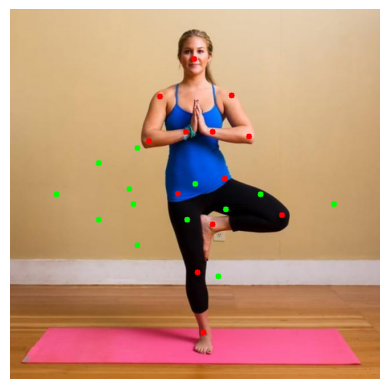

In [82]:
for x, y in gt_kpts:
    cv2.circle(Image, (int(x), int(y)), 5, (255, 0, 0), -1)  # Red circles for ground truth keypoints

for x,y in hrnet_kp:
    cv2.circle(Image, (int(x), int(y)), 5, (0, 255, 0), -1)  # Green circles for predicted keypoints

# Display the image with keypoints
plt.imshow(Image)
plt.axis('off')
plt.show()

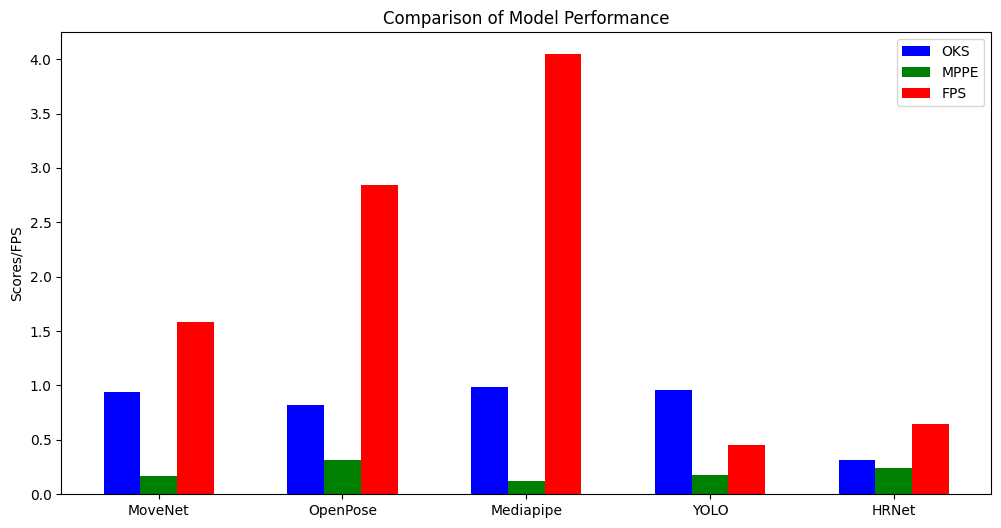

In [85]:
import matplotlib.pyplot as plt

# Data for the bar chart
models = ['MoveNet', 'OpenPose', 'Mediapipe', 'YOLO', 'HRNet']
oks_scores = [0.9395996464947987, 0.8236092999642884, 0.9821155752858517, 0.955230686123923, 0.31647941786667094]
mppe_scores = [0.1714874787467772, 0.3137391275287005, 0.12402084693643761, 0.17318164422338678, 0.24330569598117685]
fps_scores = [1.5822588597621956, 2.8464790777913356, 4.044675282595656, 0.4499748261945327, 0.6438802193271034]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Define the width of the bars
bar_width = 0.2

# Create the bars for OKS scores
x = range(len(models))
ax.bar([i - bar_width for i in x], oks_scores, width=bar_width, label='OKS', color='blue')

# Create the bars for MPPE scores
ax.bar(x, mppe_scores, width=bar_width, label='MPPE', color='green')

# Create the bars for FPS scores
ax.bar([i + bar_width for i in x], fps_scores, width=bar_width, label='FPS', color='red')

# Set the x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(models)

# Set the y-axis label
ax.set_ylabel('Scores/FPS')

# Set the title
ax.set_title('Comparison of Model Performance')

# Add a legend
ax.legend()

# Display the plot
plt.show()